In [1]:
#### network.ipynb
# A module to implement the stochastic gradient descent learning algorithm for a feedforward neural network.
# Gradients are calculated using backpropagation.  Note that I have focused on making the code simple, easily readable, and easily modifiable.

In [2]:
#### Libraries
# Standard library
import random

In [3]:
# Third-party libraries
import numpy as np
import matplotlib.pyplot as plt


In [4]:
class Network(object):

    def __init__(self, sizes):
        """The list ``sizes`` contains the number of neurons in the
        respective layers of the network.  For example, if the list
        was [2, 3, 1] then it would be a three-layer network, with the
        first layer containing 2 neurons, the second layer 3 neurons,
        and the third layer 1 neuron.  The biases and weights for the
        network are initialized randomly, using a Gaussian
        distribution with mean 0, and variance 1.  Note that the first
        layer is assumed to be an input layer, and by convention we
        won't set any biases for those neurons, since biases are only
        ever used in computing the outputs from later layers."""
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(sizes[:-1], sizes[1:])]

    def feedforward(self, a):
        """Return the output of the network if ``a`` is input."""
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a)+b)
        return a

    def SGD(self, training_data, epochs, mini_batch_size, eta,
            test_data=None):
        """Train the neural network using mini-batch stochastic
        gradient descent.  The ``training_data`` is a list of tuples
        ``(x, y)`` representing the training inputs and the desired
        outputs.  The other non-optional parameters are
        self-explanatory.  If ``test_data`` is provided then the
        network will be evaluated against the test data after each
        epoch, and partial progress printed out.  This is useful for
        tracking progress, but slows things down substantially."""
        if test_data: n_test = len(test_data)
        n = len(training_data)
        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)
            if test_data:
                print("Epoch {0}: {1} / {2}".format(
                    j, self.evaluate(test_data), n_test))
            else:
                print("Epoch {0} complete".format(j))

    def update_mini_batch(self, mini_batch, eta):
        """Update the network's weights and biases by applying
        gradient descent using backpropagation to a single mini batch.
        The ``mini_batch`` is a list of tuples ``(x, y)``, and ``eta``
        is the learning rate."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [w-(eta/len(mini_batch))*nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb
                       for b, nb in zip(self.biases, nabla_b)]

    def backprop(self, x, y):
        """Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x.  ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        # backward pass
        delta = self.cost_derivative(activations[-1], y) * \
            sigmoid_prime(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        # Note that the variable l in the loop below is used a little
        # differently to the notation in Chapter 2 of the book.  Here,
        # l = 1 means the last layer of neurons, l = 2 is the
        # second-last layer, and so on.  It's a renumbering of the
        # scheme in the book, used here to take advantage of the fact
        # that Python can use negative indices in lists.
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)

    def evaluate(self, test_data):
        """Return the number of test inputs for which the neural
        network outputs the correct result. Note that the neural
        network's output is assumed to be the index of whichever
        neuron in the final layer has the highest activation."""
        test_results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in test_data]
        return sum(int(x == y) for (x, y) in test_results)

    def cost_derivative(self, output_activations, y):
        # Return the vector of partial derivatives \partial C_x / \partial a for the output activations.
        return (output_activations-y)

In [5]:
#### Miscellaneous functions
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))

In [6]:
def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))

In [7]:
# mnist_loader
# A library to load the MNIST image data.  For details of the data structures that are returned, see the doc strings for ``load_data``
# and ``load_data_wrapper``.  In practice, ``load_data_wrapper`` is the function usually called by our neural network code.

In [8]:
#### Libraries
# Standard library
import pickle
import gzip

In [9]:
# Third-party libraries
import numpy as np

In [10]:
def load_data():
    # Return the MNIST data as a tuple containing the training data, the validation data, and the test data.

    # The ``training_data`` is returned as a tuple with two entries. The first entry contains the actual training images. This is a numpy ndarray 
    # with 50,000 entries. Each entry is, in turn, a numpy ndarray with 784 values, representing the 28 * 28 = 784 pixels in a single MNIST image.

    # The second entry in the ``training_data`` tuple is a numpy ndarray containing 50,000 entries.  Those entries are just the digit values
    # (0...9) for the corresponding images contained in the first entry of the tuple.

    # The ``validation_data`` and ``test_data`` are similar, except ach contains only 10,000 images.

    # This is a nice data format, but for use in neural networks it's helpful to modify the format of the ``training_data`` a little.
    # That's done in the wrapper function ``load_data_wrapper()``, see below.

    f = gzip.open('mnist.pkl.gz', 'rb')
    training_data, validation_data, test_data = pickle.load(f, encoding="latin1")
    f.close()
    return (training_data, validation_data, test_data)
    

In [11]:
def load_data_wrapper():
    # Return a tuple containing ``(training_data, validation_data, test_data)``. Based on ``load_data``,
    # but the format is more convenient for use in our implementation of neural networks.

    # In particular, ``training_data`` is a list containing 50,000 2-tuples ``(x, y)``.  ``x`` is a 784-dimensional numpy.ndarray containing 
    # the input image. ``y`` is a 10-dimensional numpy.ndarray representing the unit vector corresponding to the correct digit for ``x``.

    # ``validation_data`` and ``test_data`` are lists containing 10,000 2-tuples ``(x, y)``.  In each case, ``x`` is a 784-dimensional numpy.ndarry
    # containing the input image, and ``y`` is the corresponding classification, i.e., the digit values (integers) corresponding to ``x``.

    # Obviously, this means we're using slightly different formats for the training data and the validation / test data.  These formats
    # turn out to be the most convenient for use in our neural network code
    
    tr_d, va_d, te_d = load_data()
    training_inputs = [np.reshape(x, (784, 1)) for x in tr_d[0]]
    training_results = [vectorized_result(y) for y in tr_d[1]]
    training_data = list(zip(training_inputs, training_results))
    validation_inputs = [np.reshape(x, (784, 1)) for x in va_d[0]]
    validation_data = list(zip(validation_inputs, va_d[1]))
    test_inputs = [np.reshape(x, (784, 1)) for x in te_d[0]]
    test_data = list(zip(test_inputs, te_d[1]))
    return (training_data, validation_data, test_data)

In [12]:
def vectorized_result(j):
    # Return a 10-dimensional unit vector with a 1.0 in the jth position and zeroes elsewhere. 
    # This is used to convert a digit (0...9) into a corresponding desired output from the neural network.
    
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

In [13]:
def run_experiments():
    training_data, validation_data, test_data = load_data_wrapper()
    
    learning_rates = list(range(1, 20, 2))  
    accuracies = []

    for eta in learning_rates:
        print(f"\nTraining with learning rate η = {eta}...")
        net = Network([784, 30, 10])
        net.SGD(training_data, epochs=30, mini_batch_size=10, eta=eta, test_data=test_data)

        accuracy = net.evaluate(test_data) / len(test_data)
        accuracies.append(accuracy)

        print(f"Accuracy: {accuracy:.4f}")

    # Plot results
    plt.figure(figsize=(10, 5))
    plt.plot(learning_rates, accuracies, marker='o')
    plt.title("Classification Accuracy vs Learning Rate")
    plt.xlabel("Learning Rate (η)")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Report optimal learning rate
    best_idx = np.argmax(accuracies)
    best_eta = learning_rates[best_idx]
    best_acc = accuracies[best_idx]

    print(f"\nBest learning rate: η = {best_eta}")
    print(f"Highest accuracy: {best_acc:.4f}")



Training with learning rate η = 1...
Epoch 0: 8700 / 10000
Epoch 1: 9022 / 10000
Epoch 2: 9147 / 10000
Epoch 3: 9204 / 10000
Epoch 4: 9226 / 10000
Epoch 5: 9255 / 10000
Epoch 6: 9271 / 10000
Epoch 7: 9278 / 10000
Epoch 8: 9318 / 10000
Epoch 9: 9324 / 10000
Epoch 10: 9334 / 10000
Epoch 11: 9360 / 10000
Epoch 12: 9373 / 10000
Epoch 13: 9369 / 10000
Epoch 14: 9378 / 10000
Epoch 15: 9385 / 10000
Epoch 16: 9379 / 10000
Epoch 17: 9421 / 10000
Epoch 18: 9396 / 10000
Epoch 19: 9419 / 10000
Epoch 20: 9409 / 10000
Epoch 21: 9409 / 10000
Epoch 22: 9418 / 10000
Epoch 23: 9424 / 10000
Epoch 24: 9423 / 10000
Epoch 25: 9415 / 10000
Epoch 26: 9435 / 10000
Epoch 27: 9424 / 10000
Epoch 28: 9415 / 10000
Epoch 29: 9435 / 10000
Accuracy: 0.9435

Training with learning rate η = 3...
Epoch 0: 9114 / 10000
Epoch 1: 9250 / 10000
Epoch 2: 9317 / 10000
Epoch 3: 9335 / 10000
Epoch 4: 9369 / 10000
Epoch 5: 9392 / 10000
Epoch 6: 9414 / 10000
Epoch 7: 9424 / 10000
Epoch 8: 9442 / 10000
Epoch 9: 9425 / 10000
Epoch 1

C:\Users\msidd\AppData\Local\Temp\ipykernel_13508\3064067696.py:4: RuntimeWarning: overflow encountered in exp
  return 1.0/(1.0+np.exp(-z))


Epoch 26: 9423 / 10000
Epoch 27: 9416 / 10000
Epoch 28: 9304 / 10000
Epoch 29: 9402 / 10000
Accuracy: 0.9402

Training with learning rate η = 19...
Epoch 0: 4567 / 10000
Epoch 1: 5512 / 10000
Epoch 2: 7974 / 10000
Epoch 3: 8064 / 10000
Epoch 4: 8880 / 10000
Epoch 5: 9034 / 10000
Epoch 6: 8952 / 10000
Epoch 7: 9082 / 10000
Epoch 8: 9098 / 10000
Epoch 9: 9149 / 10000
Epoch 10: 9066 / 10000
Epoch 11: 9036 / 10000
Epoch 12: 9159 / 10000
Epoch 13: 9178 / 10000
Epoch 14: 9129 / 10000
Epoch 15: 9139 / 10000
Epoch 16: 9160 / 10000
Epoch 17: 9100 / 10000
Epoch 18: 9233 / 10000
Epoch 19: 9218 / 10000
Epoch 20: 9181 / 10000
Epoch 21: 9165 / 10000
Epoch 22: 9209 / 10000
Epoch 23: 9185 / 10000
Epoch 24: 9192 / 10000
Epoch 25: 9241 / 10000
Epoch 26: 9185 / 10000
Epoch 27: 9272 / 10000
Epoch 28: 9168 / 10000
Epoch 29: 9276 / 10000
Accuracy: 0.9276


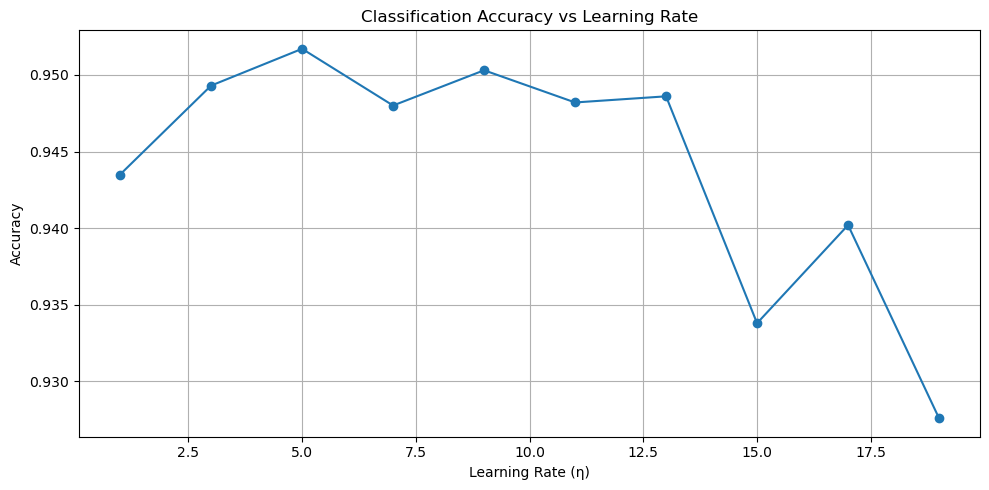


Best learning rate: η = 5
Highest accuracy: 0.9517


In [14]:
# It is time to call the function run_experiments() to execute all the commands
run_experiments()